In [4]:
# Import all modules for exploratory data analysis

# Extract and save data from database
import db_utils as dbu
# Change datatype of columns to the appripriate ones
import pre_processing as prep
# Get descritve informarion from the dataframe
import extract_info as extract 
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


In [5]:
# Extract cloud database credentials from yaml file
db_credentials = dbu.read_credentials("/Users/ChAre/OneDrive/Desktop/aicore/EDA_finance/credentials.yaml")

# Extracting the data from Amazon RDS

In [6]:
# Initialise RDSDatabaseConnector class
db_connector = dbu.RDSDatabaseConnector(db_credentials)

In [ ]:
# Connect to database and extract desire database in the cloud
# RDSDatabaseConnector.save_data() call upon: extract_data, 
db_connector.save_data()

In [7]:
# Load data into pyhton
df_unclean = db_connector.load_data("./loan_payments")

# Data preprocessing

In [ ]:
# Inspect the columns data types
df_unclean.info()

In [9]:
# Create instance of preprocessing of DataTransform class for preprocessing.
df_prep = prep.DataTransform(df_unclean)

In [10]:
# Transform columns into the categorical data type
df_prep.category_transform(["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "payment_plan", "purpose", "application_type", "employment_length", "policy_code"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


In [11]:
# Convert columns to date type data
df_prep.date_transform(["issue_date", "earliest_credit_line", "last_payment_date", "next_payment_date", "last_credit_pull_date"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,NaN,1,INDIVIDUAL


In [ ]:
# Preporcess term column

# Convert column values into strings
df_prep.string_transform(["term"])

# Remove unwanted characters from the column values
df_prep.remove_characters("term", ["months"])

# Transform column values to numeric
df_prep.numeric_transform(["term"])

#Rename column to reflect the unit for the values
df_prep.rename_column("term", "term_in_months")

In [16]:
# Create DataFrameInfo instance to extract useful information from the dataframe.
df_inf = extract.DataFrameInfo(df_prep.dataframe)

In [17]:
# Check the data types of the columns after the transformations.
df_inf.check_columns_type()

id                                      int64
member_id                               int64
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term                                   object
int_rate                              float64
instalment                            float64
grade                                category
sub_grade                            category
employment_length                    category
home_ownership                       category
annual_inc                            float64
verification_status                  category
issue_date                     datetime64[ns]
loan_status                          category
payment_plan                         category
purpose                              category
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line           datetime64[ns]
inq_last_6mths                    

In [ ]:
# Extract statistical values: median, standard deviation and mean from the columns
# Omitted the id and member_id columns because they are used just for identifying individuals
df_inf.descriptive_stats( ["id", "member_id"]) 

In [ ]:
# Count distinct values in categorical columns
df_inf.unique_valus_count()

In [ ]:
# Print out the shape of the DataFrame
df_inf.data_shape()

In [ ]:
# Generate a count/percentage count of NULL values in each column
df_inf.count_null(percentage=True)

Base on the percentage of missing data I decided to:
drop:
 - mths_since_last_delinq:        57.2% missing values
 - mths_since_last_record:        88.6% missing values
 - mths_since_last_major_derog    86.2% missing values

Impute:
- funded_amount                   5.5% missing values
- term_in_months                  8.8% missing values
- int_rate                        9.5% missing values
- employment_length               3.9% missing values
- last_payment_date               0.1% missing values
- last_credit_pull_date           0.013% missing values
- collections_12_mths_ex_med      0.094% missing values
- next_payment_date               86.2%  missing values

Although the next_payment_date column has 86.2% of missing values, it can be useful to project profit in the following months. Therefore I chose to impute it. I also prioritise imputing values rather than droppoing rows since it will will reduce the data in other column makeing it less reliable to impute values.

In [ ]:
# Dropping columns
df_prep.remove_columns(["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"])

Since most of the columns to impute have a low percentage of missing data I decide to use the mean or the median. To decide which of the two method I should use for each column I will carry a normality test for each column.

In [ ]:
from scipy.stats import normaltest
def norm_test(dataframe, column):
    data = dataframe[column]
    stat, p = normaltest(data, nan_policy='omit')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
# Normality test
norm_test(df_prep.dataframe,"funded_amount")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="funded_amount", bins= 50, kde=True)
plt.title('Distribution of the total amount committed to the loan at that point in time.')
plt.xlabel('total amount committed to the loan')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()
# QQplot
qq_plot = qqplot(df_prep.dataframe["funded_amount"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.


In [ ]:
# Imputing "funded_amount" using the median

# Get the mendian
df_inf.descriptive_stats(selected_column=["funded_amount"])
# replace null values
df_prep.replace_null("funded_amount", 12000.0)


In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# Normality test
norm_test(df_prep.dataframe, "term_in_months")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="term_in_months", bins= 10)
plt.title('Distribution of the total total monthly payments for the loan')
plt.xlabel('Number of monthly payments')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

# QQplot
qq_plot = qqplot(df_prep.dataframe["term_in_months"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is only two values and since is categorical we impute the null values using the median. 

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["term_in_months"])
# replace null values
df_prep.replace_null("term_in_months", 36.0)

In [ ]:
# Normality test
norm_test(df_prep.dataframe, "int_rate")
# Historgram
df_prep.dataframe["int_rate"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["int_rate"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["int_rate"])
# replace null values
df_prep.replace_null("int_rate", 13.16)

In [ ]:

# Historgram
df_prep.dataframe["last_payment_date"].hist(bins=20)

The histogram showed significant skewness of the data but since the data is date type the median.

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_payment_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))

In [ ]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_credit_pull_date", bins= 5)
plt.title('Distribution of the most recent month that the loan company pulled credit for this loan')
plt.xlabel('Most recent month')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [ ]:
# Impute values of the "last_payment_date column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_credit_pull_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))

In [ ]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="collections_12_mths_ex_med", bins= 5)
plt.title('Distribution of the Number of collections in 12 months excluding medical collections')
plt.xlabel('Number of collections')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# Get the median
df_inf.descriptive_stats(selected_column=["collections_12_mths_ex_med"])
# replace null values
df_prep.replace_null("collections_12_mths_ex_med", 0.0)

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="next_payment_date", bins= 5)
plt.title('Distribution of the next scheduled payment date')
plt.xlabel('Next schedual payment date')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="employment_length", bins= 5)
plt.title('Duration in which the client has been working')
plt.xlabel('Lenght of employment')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed skweness of the data and since it is categorical data, I will use the mode to impute the missing values.

In [ ]:
# Get the mode
df_prep.dataframe["employment_length"].mode()
# replace null values
df_prep.replace_null("employment_length",  "10+ years")


In [ ]:
df = pd.read_csv("./loan_payments")

In [ ]:
plt.figure(figsize=(12,8))
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.05
)

In [ ]:
def null_plot(self):
    """
    This function:
        Creates a density plot of missing values for all columns of a selected dataframe.
    """
    plt.figure(figsize=(12,8))
    sns.displot(
        data= self.dataframe.isnull().melt(value_name="missing"),
        y="variable",
        hue="missing",
        multiple="fill",
        aspect=1.05
    )

<Figure size 1200x800 with 0 Axes>

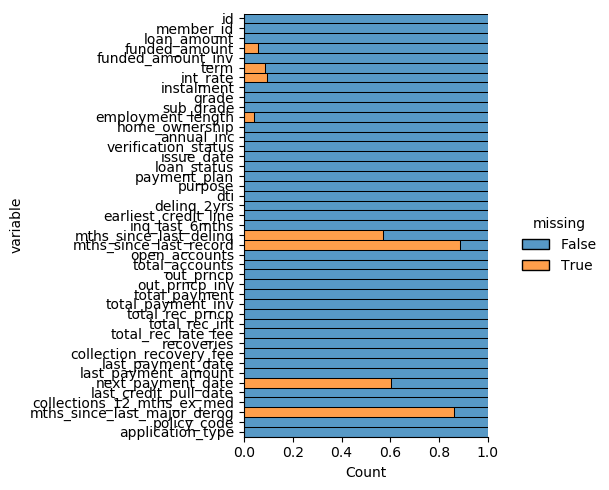

In [7]:
import plot as plo
plots = plo.Plotter(df_prep.dataframe)
plots.missing_values_plot()

In [14]:
def skew_check_numeric(dataframe, columns = [], bins_size=40):
    if len(columns) == 0:
        for column in dataframe:
            if dataframe[column].dtype == "float64" or  dataframe[column].dtype == "int64":
                column_skewness = dataframe[column].skew(axis=1)
                if column_skewness >= 0.5:
                    return f"{column}: \nskewness:{column_skewness}"
             
    elif len(columns) > 0:
        for column in columns:
             if dataframe[column].dtype == "float64" or  dataframe[column].dtype == "int64":
                column_skewness = dataframe[column].skew()
                if column_skewness >= 0.5:
                    return f"{column}: \nskewness:{column_skewness}"
                
    #elif len(columns) ==1 and dataframe[column].dtype == "category":
        #dataframe[column].hist(bins=bins_size)
        

    


In [15]:
skew_check(df_prep.dataframe)

UnboundLocalError: local variable 'column' referenced before assignment